In [109]:
import numpy as np
import cv2 as cv
cv2 = cv
import matplotlib.pyplot as plt

In [485]:
champ = 'morgana17'
img1 = cv.imread(champ + '_crop.jpg',     cv.IMREAD_ANYCOLOR) # queryImage
print(img1.shape)
img2 = cv.imread(champ + '_original.jpg', cv.IMREAD_ANYCOLOR) # trainImage

scaling = round(img2.shape[0] / img1.shape[0])
print('scaling:', scaling)
img1 = cv.resize(img1, (img1.shape[1] // 1, img1.shape[0] // 1))
img2 = cv.resize(img2, (img2.shape[1] // scaling, img2.shape[0] // scaling))

# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

(560, 308, 3)
scaling: 1


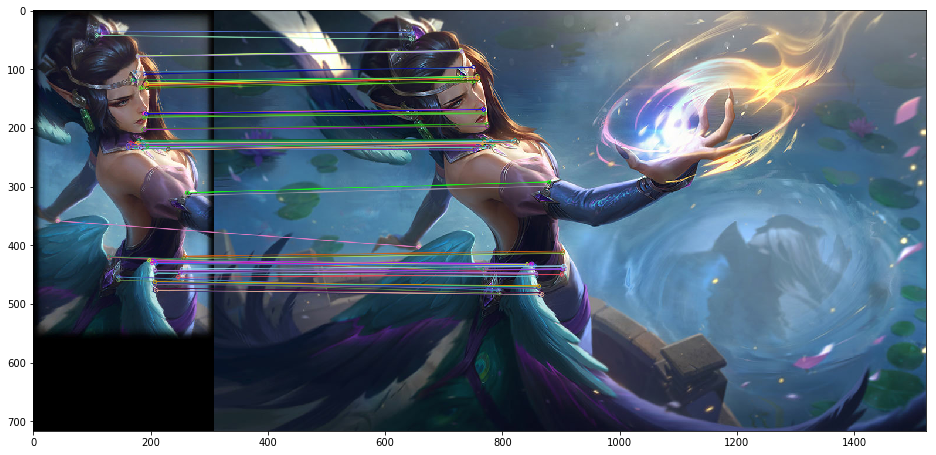

In [486]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1, des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x: x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1, kp1, img2, kp2, matches[:100], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=(16, 10))
ax.imshow(img3)

In [487]:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
good = matches[:100]
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1, 1, 2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1, 1, 2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0)
matchesMask = mask.ravel().tolist()

h, w = img1.shape[:2]
pts = np.float32([
    [ 0, 0 ],
    [ 0, h - 1 ],
    [ w - 1, h - 1 ],
    [ w - 1, 0 ]
]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, M)

img2 = cv2.polylines(img2, [ np.int32(dst) ], True, 255, 3, cv2.LINE_AA)

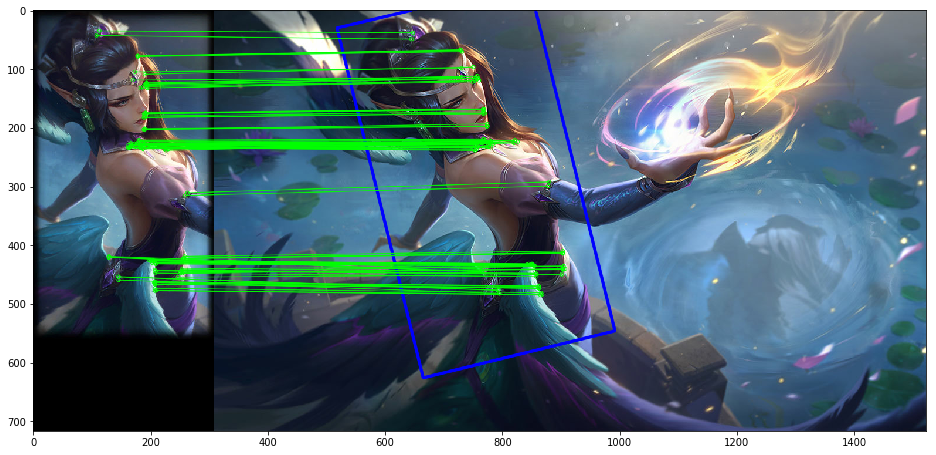

(<matplotlib.image.AxesImage at 0x298e6312390>, None)

In [488]:
draw_params = dict(matchColor = (0, 255, 0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img4 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
img4 = cv.cvtColor(img4, cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=(16, 10))
ax.imshow(img4, 'gray'),plt.show()

[[ 8.87637891e-01 -2.21454443e-01 -1.80107118e+02]
 [ 2.18332979e-01  8.83528851e-01 -7.32610861e+01]
 [ 2.86606622e-06 -5.03729496e-06  1.00000000e+00]]


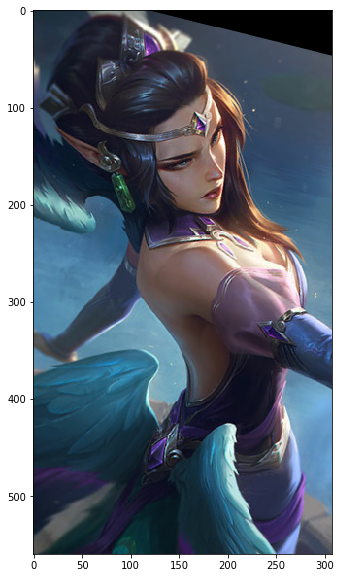

In [489]:
M_inv, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
print(M_inv)
# M_inv = np.array([
#     [ 8, 0, 0 ],
#     [ 0, 8, 0 ],
#     [ 0, 0, 1 ]
# ]) @ M_inv
M_inv[0, 2] *= scaling
M_inv[1, 2] *= scaling

src = cv.imread(champ + '_original.jpg', cv.IMREAD_ANYCOLOR)
#src = cv.resize(src, (src.shape[1] // scaling, src.shape[0] // scaling))

dst = cv2.warpAffine(src, M_inv[:2, :], (scaling * img1.shape[1], scaling * img1.shape[0]))
cv2.imwrite(champ + "_out.jpg", dst)

dst = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(16, 10))
ax.imshow(dst)


30


True

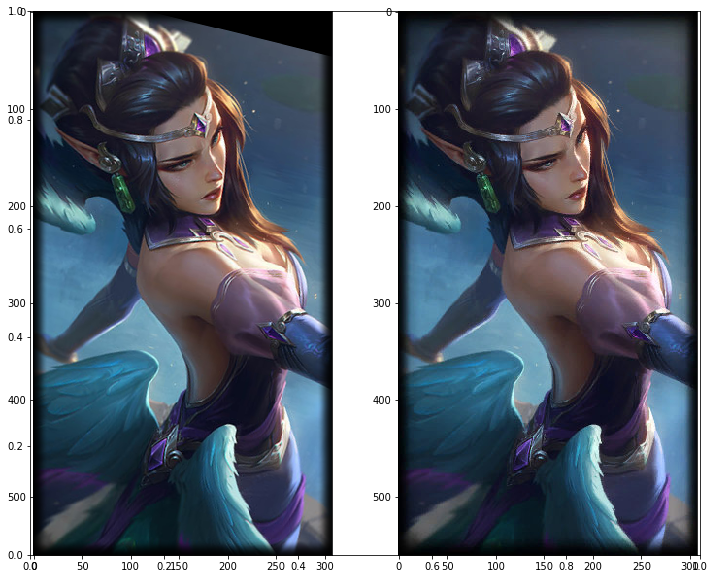

In [490]:
# vignette
rows, cols = dst.shape[:2]
#a = cv2.getGaussianKernel(cols // 10, cols ** 0.5)
a = cv2.getGaussianKernel(cols // 10, cols / 50)
c = a @ a.T
d = c / c.max()


size = a.shape[0]
half = size // 2
print(size)

d = np.hstack([
    d[:, :half],
    np.tile(d[:, half:half+1], (1, 1 + cols - size)),
    d[:, half+1:]
])
d = np.vstack([
    d[:half],
    np.tile(d[half:half+1], (1 + rows - size, 1)),
    d[half+1:]
])

dst = (dst.astype('float64') * d[:,:,np.newaxis]).astype('uint8')

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=(12, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(dst)
fig.add_subplot(1, 2, 2)
plt.imshow(img1)

dst = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
cv2.imwrite(champ + "_out_vig.jpg", dst)